In [1]:
import torch
import torchvision
# pytorch lightning
import pytorch_lightning as pl


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_dir = 'data/images'
#load image folder
train_images=torchvision.datasets.ImageFolder(root=data_dir+'/train',transform=torchvision.transforms.ToTensor())
valida_images=torchvision.datasets.ImageFolder(root=data_dir+'/validation',transform=torchvision.transforms.ToTensor())



In [3]:
train_dataset=torch.utils.data.DataLoader(train_images,batch_size=256,shuffle=True)
valida_dataset=torch.utils.data.DataLoader(valida_images,batch_size=256,shuffle=True)

#move to gpu
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
#basic cnn model
#input is 48x48x3
#output is 8
#conv-32x3-relu-maxpool-conv-32x3-relu-maxpool-fc-1024-relu-fc-1024-relu-fc-8
classes=train_images.classes
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=torch.nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu1=torch.nn.ReLU()
        self.maxpool1=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2=torch.nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu2=torch.nn.ReLU()
        self.maxpool2=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1=torch.nn.Linear(in_features=32*12*12,out_features=1024)
        self.relu3=torch.nn.ReLU()
        self.fc2=torch.nn.Linear(in_features=1024,out_features=1024)
        self.relu4=torch.nn.ReLU()
        self.fc3=torch.nn.Linear(in_features=1024,out_features=len(classes))
        self.softmax=torch.nn.Softmax(dim=1)
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.maxpool2(x)

        x=x.view(-1,32*12*12)
        x=self.fc1(x)
        x=self.relu3(x)
        x=self.fc2(x)
        x=self.relu4(x)
        x=self.fc3(x)
        return x

model=CNN().to(device)


In [15]:
#train model
#loss function
criterion=torch.nn.CrossEntropyLoss()
#optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=10
for epoch in range(epochs):
    for i,(images,labels) in enumerate(train_dataset):
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=model(images)
        loss=criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1)%100==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1,epochs,i+1,len(train_dataset),loss.item()))
        if epoch==10:
            #print training accuracy
            correct=0
            total=0
            with torch.no_grad():
                for images,labels in train_dataset:
                    images=images.to(device)
                    labels=labels.to(device)
                    outputs=model(images)
                    # apply softmax to get probabilities
                    prob = torch.nn.functional.softmax(outputs, dim=1)
                    # get the index of the max probability
                    predicted = torch.max(prob, 1)[1]
                    total+=labels.size(0)
                    correct+=(predicted==labels).sum().item()
            print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

Epoch [1/10], Step [100/113], Loss: 1.5975
Epoch [2/10], Step [100/113], Loss: 1.3742
Epoch [3/10], Step [100/113], Loss: 1.3368
Epoch [4/10], Step [100/113], Loss: 1.2944
Epoch [5/10], Step [100/113], Loss: 1.0280
Epoch [6/10], Step [100/113], Loss: 0.9496
Epoch [7/10], Step [100/113], Loss: 0.8938
Epoch [8/10], Step [100/113], Loss: 0.7163
Epoch [9/10], Step [100/113], Loss: 0.4250
Epoch [10/10], Step [100/113], Loss: 0.2875


In [28]:
#check accuracy
correct=0
total=0
with torch.no_grad():
    for images,labels in valida_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        # apply softmax to get probabilities
        prob = torch.nn.functional.softmax(outputs, dim=1)
        predicted = torch.max(prob, 1)[1]
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: {} %'.format(100*correct/total))
correct=0
total=0
with torch.no_grad():
    for images,labels in train_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        # apply softmax to get probabilities
        prob = torch.nn.functional.softmax(outputs, dim=1)
        predicted = torch.max(prob, 1)[1]
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
from pytorch_lightning.callbacks.progress import TQDMProgressBar

class FaceDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = 'data/images', batch_size: int = 256):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self):
        # download, split, etc...
        # called only on 1 GPU
        pass

    def setup(self, stage=None):
        # make assignments here (val/train/test split)
        # called on every GPU
        train_images=torchvision.datasets.ImageFolder(root=self.data_dir+'/train',transform=torchvision.transforms.ToTensor())
        valida_images=torchvision.datasets.ImageFolder(root=self.data_dir+'/validation',transform=torchvision.transforms.ToTensor())
        self.train_dataset=torch.utils.data.DataLoader(train_images,batch_size=self.batch_size,shuffle=True)
        self.valida_dataset=torch.utils.data.DataLoader(valida_images,batch_size=self.batch_size,shuffle=True)

    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.valida_dataset

    def test_dataloader(self):
        return self.valida_dataset

class CNN(pl.LightningModule):
    def __init__(self,classes):
        super().__init__()
        self.classes=classes
        self.conv1=torch.nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu1=torch.nn.ReLU()
        self.maxpool1=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2=torch.nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu2=torch.nn.ReLU()
        self.maxpool2=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1=torch.nn.Linear(in_features=32*12*12,out_features=1024)
        self.relu3=torch.nn.ReLU()
        self.fc2=torch.nn.Linear(in_features=1024,out_features=1024)
        self.relu4=torch.nn.ReLU()
        self.fc3=torch.nn.Linear(in_features=1024,out_features=len(classes))
        self.softmax=torch.nn.Softmax(dim=1)
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.maxpool2(x)

        x=x.view(-1,32*12*12)
        x=self.fc1(x)
        x=self.relu3(x)
        x=self.fc2(x)
        x=self.relu4(x)
        x=self.fc3(x)
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = CNN(classes)
dm = FaceDataModule()
# accuracy callback

trainer = pl.Trainer(gpus=1, max_epochs=10,callbacks=[TQDMProgressBar(refresh_rate=20)])
trainer.fit(model, dm)



/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type      | Params
----------------------------------------
0  | conv1    | Conv2d    | 896   
1  | relu1    | ReLU      | 0     
2  | maxpool1 | MaxPool2d | 0     
3  | conv2    | Conv2d    | 9.2 K 
4  | relu2    | ReLU      | 0     
5  | maxpool2 | MaxPool2d | 0     
6  | fc1      | Linear    | 4.7 M 
7  | relu3    | ReLU      | 0     
8  | fc2      | Linear    | 1.0 M 
9  | relu4    | ReLU      | 0     
10 | fc3      | Linear    | 7.2 K 
11 | softmax  | Soft

Sanity Checking: 0it [00:00, ?it/s]

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
import torchvision.models as models
#efficicentnet v2
model=models.efficientnet_b0(pretrained=True)
#change output to 7
model.classifier[1]=torch.nn.Linear(in_features=1280,out_features=len(classes))
model.to(device)


AttributeError: module 'torchvision.models' has no attribute 'efficientnet_b0'

In [35]:
%%time
#train model
#loss function
criterion=torch.nn.CrossEntropyLoss()
#optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=10
for epoch in range(epochs):
    for i,(images,labels) in enumerate(train_dataset):
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=model(images)
        loss=criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1,epochs,i+1,len(train_dataset),loss.item()))
        if epoch==10:
            #print training accuracy
            correct=0
            total=0
            with torch.no_grad():
                for images,labels in train_dataset:
                    images=images.to(device)
                    labels=labels.to(device)
                    outputs=model(images)
                    _,predicted=torch.max(outputs.data,1)
                    total+=labels.size(0)
                    correct+=(predicted==labels).sum().item()
            print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

Epoch [1/10], Step [1/113], Loss: 2.0680
Epoch [1/10], Step [101/113], Loss: 1.2122
Epoch [2/10], Step [1/113], Loss: 1.2357
Epoch [2/10], Step [101/113], Loss: 1.0670
Epoch [3/10], Step [1/113], Loss: 0.8656
Epoch [3/10], Step [101/113], Loss: 0.9663
Epoch [4/10], Step [1/113], Loss: 0.7455
Epoch [4/10], Step [101/113], Loss: 0.8043
Epoch [5/10], Step [1/113], Loss: 0.5502
Epoch [5/10], Step [101/113], Loss: 0.7234
Epoch [6/10], Step [1/113], Loss: 0.5178
Epoch [6/10], Step [101/113], Loss: 0.5548
Epoch [7/10], Step [1/113], Loss: 0.4499
Epoch [7/10], Step [101/113], Loss: 0.5460
Epoch [8/10], Step [1/113], Loss: 0.3071
Epoch [8/10], Step [101/113], Loss: 0.4187
Epoch [9/10], Step [1/113], Loss: 0.1966
Epoch [9/10], Step [101/113], Loss: 0.4342
Epoch [10/10], Step [1/113], Loss: 0.2421
Epoch [10/10], Step [101/113], Loss: 0.2412
CPU times: user 2min 40s, sys: 28.4 s, total: 3min 9s
Wall time: 3min 10s


In [37]:
#check accuracy
correct=0
total=0
with torch.no_grad():
    for images,labels in valida_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: {} %'.format(100*correct/total))
correct=0
total=0
with torch.no_grad():
    for images,labels in train_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

Accuracy of the network on the 10000 test images: 60.69912255873196 %
Accuracy of the network on the train images: 92.75875229867111 %


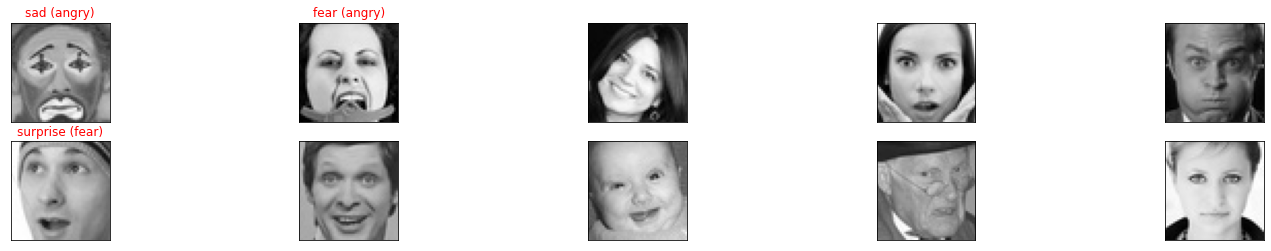

In [50]:
#plot some images
import matplotlib.pyplot as plt
import numpy as np
#get some random validation images
dataiter=iter(valida_dataset)
images,labels=dataiter.next()
images=images.to(device)
labels=labels.to(device)
#get predictions
outputs=model(images)
_,predicted=torch.max(outputs,1)
#plot the 10 images
fig=plt.figure(figsize=(25,4))
for i in range(10):
    ax=fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    img=np.squeeze(images.cpu().numpy()[i])
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    ax.imshow(img)
    ax.set_title("{} ({})".format(classes[labels[i].item()],classes[predicted[i].item()]),color="white" if labels[i].item()==predicted[i].item() else "red")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

